In [1]:
import tensorflow as tf


In [2]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

In [9]:
import pathlib
sdir = r"C:\Users\vivek\Downloads\archive (1)\Processed Images_Fruits"
bad_path = r"C:\Users\vivek\Downloads\archive (1)\Processed Images_Fruits\Bad Quality_Fruits"
good_path = r"C:\Users\vivek\Downloads\archive (1)\Processed Images_Fruits\Good Quality_Fruits"
mixed_path = r"C:\Users\vivek\Downloads\archive (1)\Processed Images_Fruits\Mixed Qualit_Fruits"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 

filepaths             labels
0      C:\Users\vivek\Downloads\archive (1)\Processed...          Apple_Bad
1      C:\Users\vivek\Downloads\archive (1)\Processed...          Apple_Bad
2      C:\Users\vivek\Downloads\archive (1)\Processed...          Apple_Bad
3      C:\Users\vivek\Downloads\archive (1)\Processed...          Apple_Bad
4      C:\Users\vivek\Downloads\archive (1)\Processed...          Apple_Bad
...                                                  ...                ...
18333  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_mixed
18334  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_mixed
18335  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_mixed
18336  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_mixed
18337  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_mixed

[18338 rows x 2 columns]

In [10]:
df['labels']=df['labels'].astype('category')

In [11]:
df['labels'].value_counts()

labels
Pomegranate_Good     4752
Orange_Good          1216
Pomegranate_Bad      1187
Orange_Bad           1159
Guava_Good           1152
Apple_Good           1149
Apple_Bad            1141
Guava_Bad            1129
Banana_Good          1113
Lime_Good            1094
Banana_Bad           1087
Lime_Bad             1085
Banana_mixed          285
Lemon_mixed           278
Guava_mixed           148
Orange_mixed          125
Pomegranate_mixed     125
Apple_mixed           113
Name: count, dtype: int64

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

df['labels'].unique()

['Apple_Bad', 'Banana_Bad', 'Guava_Bad', 'Lime_Bad', 'Orange_Bad', ..., 'Banana_mixed', 'Guava_mixed', 'Lemon_mixed', 'Orange_mixed', 'Pomegranate_mixed']
Length: 18
Categories (18, object): ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', ..., 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']

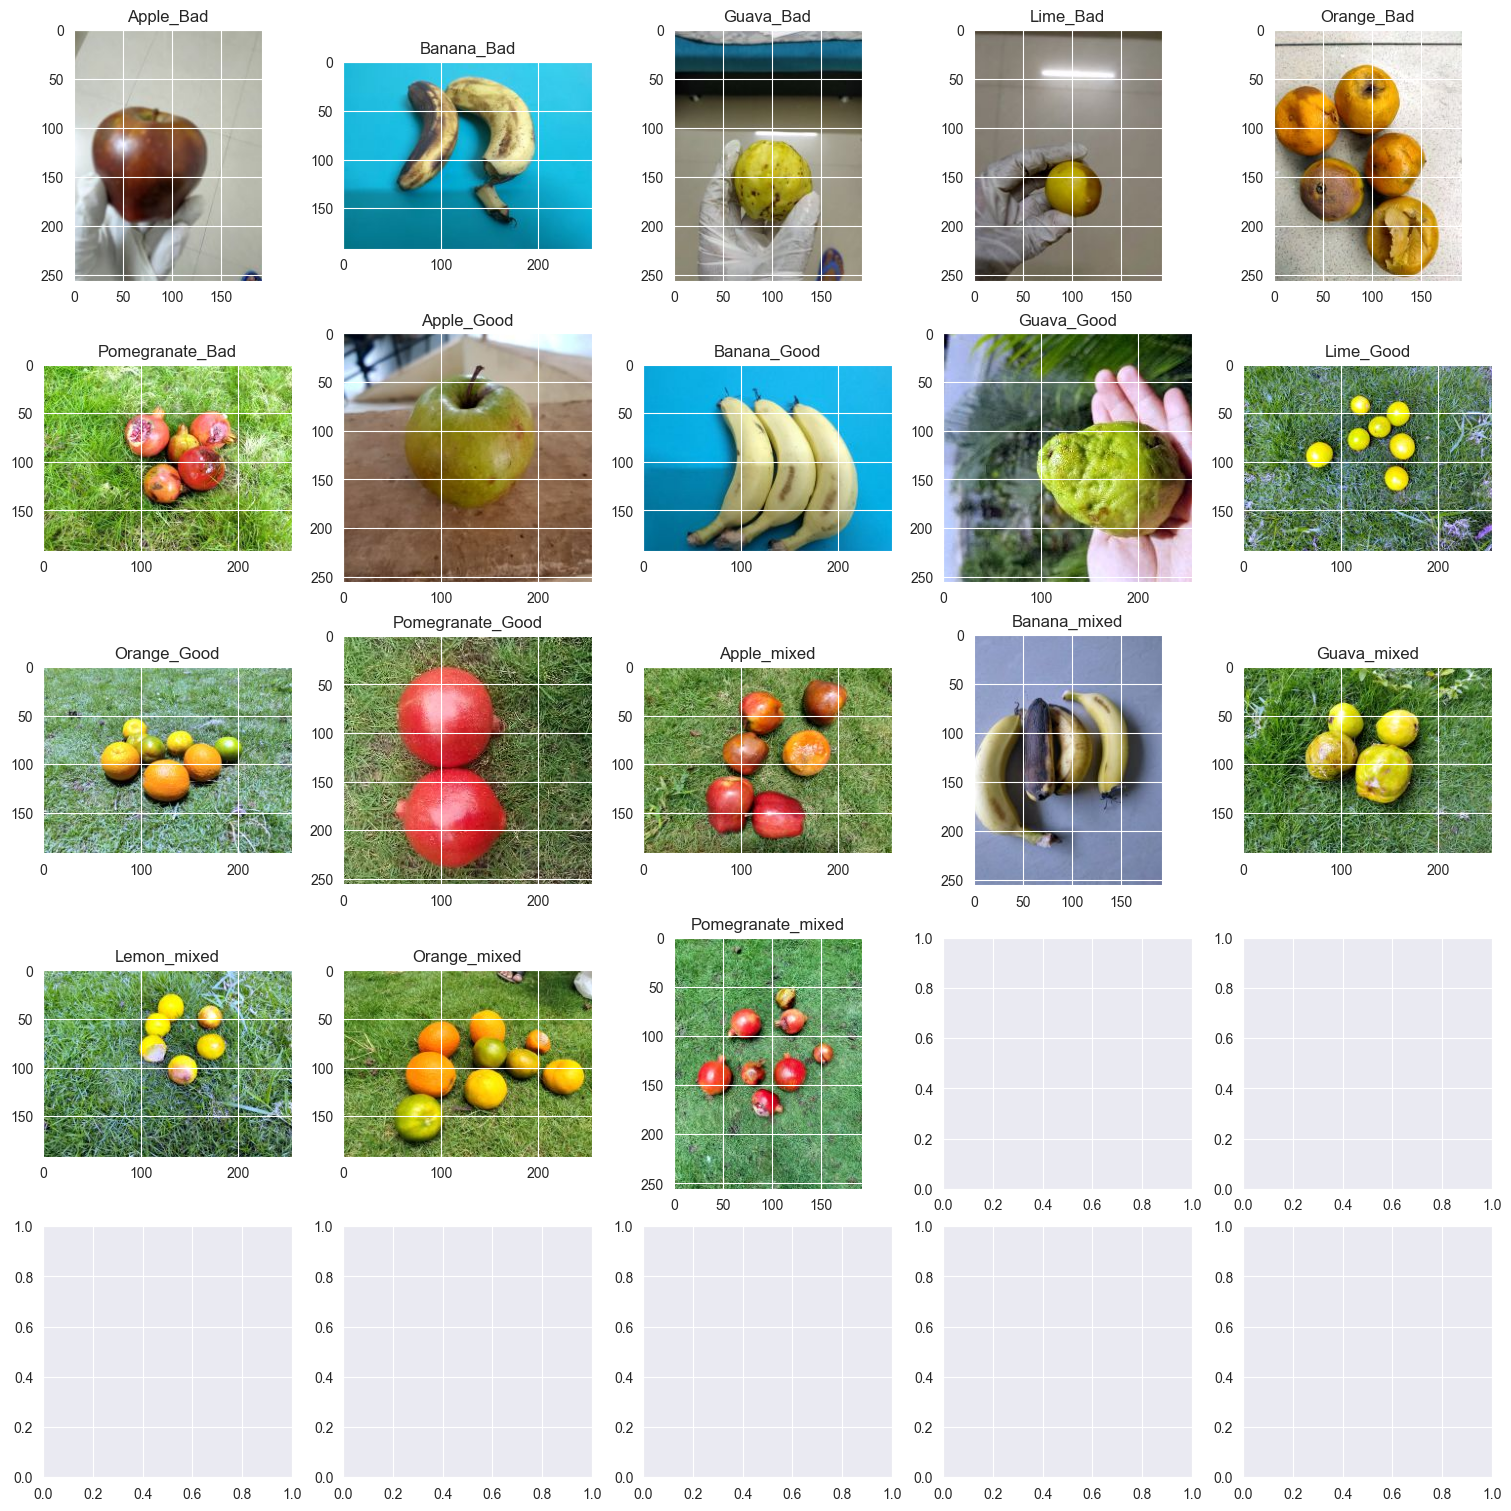

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['labels'].unique():
    
    ax[j].imshow(plt.imread(df[df['labels']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(df, test_size=0.2, random_state=123)

In [15]:
print(X_train.shape)
print(X_test.shape)

(14670, 2)
(3668, 2)


In [16]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                              validation_split=0.2)
testGen =ImageDataGenerator(preprocessing_function= preprocess_input)
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                           x_col='filepaths', 
                                           y_col='labels',
                                           class_mode='categorical', 
                                           subset='training', 
                                           batch_size=32)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                         x_col='filepaths', 
                                         y_col='labels',
                                         class_mode='categorical', 
                                         subset='validation',
                                         batch_size=32)
X_test_img =testGen.flow_from_dataframe(dataframe=X_test, 
                                        x_col='filepaths', 
                                        y_col='labels',
                                        class_mode='categorical', 
                                        batch_size=32, 
                                        shuffle=False)

Found 11736 validated image filenames belonging to 18 classes.
Found 2934 validated image filenames belonging to 18 classes.
Found 3668 validated image filenames belonging to 18 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


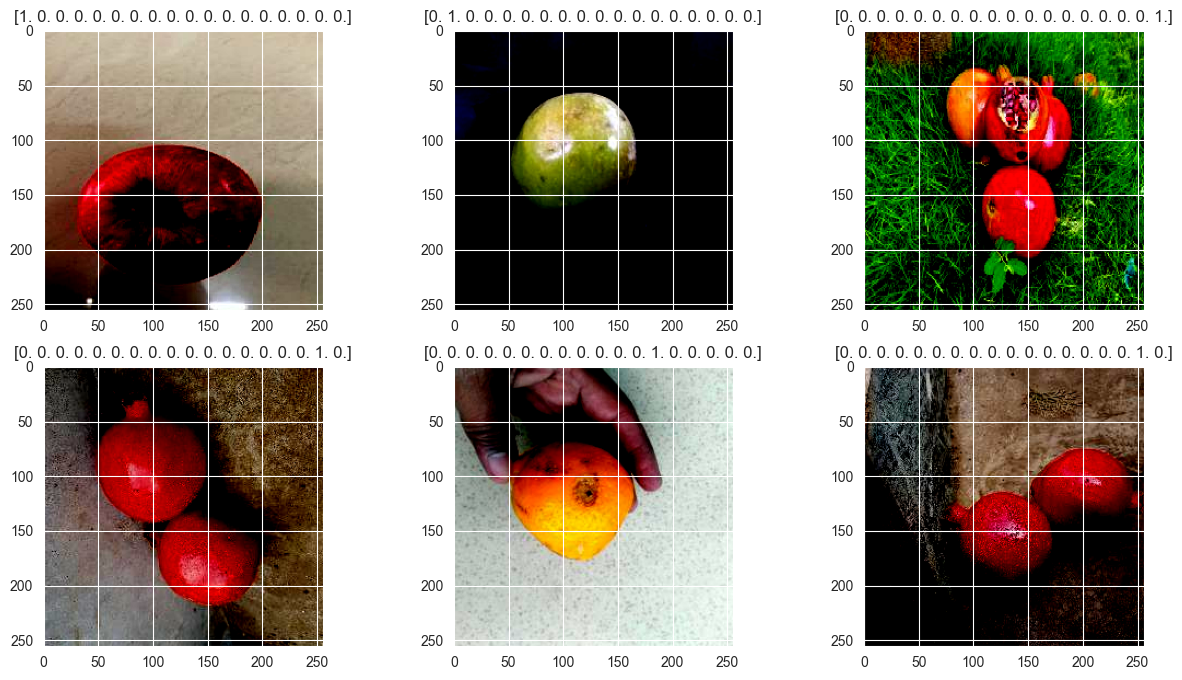

In [17]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = X_test_img.next()
    #print(img.shape)   #  (1,256,256,3)
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    #plt.show()
    j=j+1

In [16]:
X_test_img[0][0].shape

NameError: name 'X_test_img' is not defined

In [19]:
image_shape=(256,256,3)

In [20]:
X_train_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
pre_trained= InceptionResNetV2(include_top=False, input_shape=image_shape)

#for layers in pre_trained.layers:
#    layers.trainable=False
pre_trained.trainable=False

inputs = pre_trained.input
x = data_augmentation(inputs)
x = pre_trained(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output=Dense(18, activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)



base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 18)                27666 

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

initial_epoch = 10
results = model.fit(X_train_img,epochs= initial_epoch,
                              validation_data=X_val_img,
                                callbacks=[early_stop])

Epoch 1/10
367/367 [==============================] - 470s 1s/step - loss: 1.8623 - accuracy: 0.4552 - val_loss: 1.1424 - val_accuracy: 0.6892
Epoch 2/10
367/367 [==============================] - 386s 1s/step - loss: 1.0850 - accuracy: 0.6740 - val_loss: 0.8361 - val_accuracy: 0.7737
Epoch 3/10
367/367 [==============================] - 189s 516ms/step - loss: 0.8469 - accuracy: 0.7427 - val_loss: 0.6965 - val_accuracy: 0.8050
Epoch 4/10
367/367 [==============================] - 191s 520ms/step - loss: 0.7263 - accuracy: 0.7814 - val_loss: 0.6191 - val_accuracy: 0.8289
Epoch 5/10
367/367 [==============================] - 189s 514ms/step - loss: 0.6391 - accuracy: 0.8056 - val_loss: 0.5635 - val_accuracy: 0.8425
Epoch 6/10
367/367 [==============================] - 262s 714ms/step - loss: 0.5789 - accuracy: 0.8231 - val_loss: 0.5244 - val_accuracy: 0.8494
Epoch 7/10
367/367 [==============================] - 259s 705ms/step - loss: 0.5296 - accuracy: 0.8361 - val_loss: 0.4918 - val_a

Text(0.5, 1.0, 'Loss')

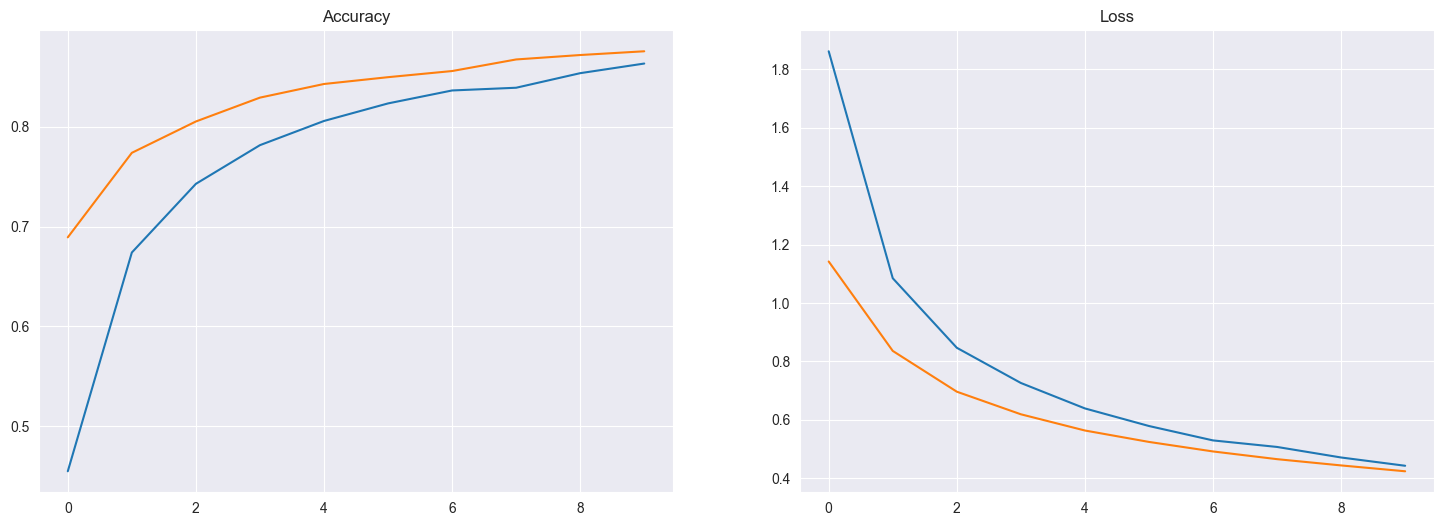

In [26]:
result_df = pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result_df[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result_df[['loss','val_loss']])
ax[1].set_title("Loss")


In [28]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

115/115 [==============================] - 42s 359ms/step


In [26]:
pred

array([ 1, 16, 11, ..., 16,  6,  7], dtype=int64)

In [29]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.888495092693566


<Axes: >

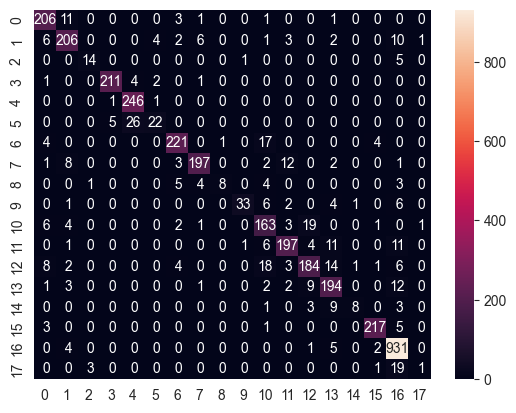

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')

Saving the training history

In [38]:
import pickle

# Save history after training
with open('training_history.pkl', 'wb') as f:
    pickle.dump(results.history, f)

Plotting the training History

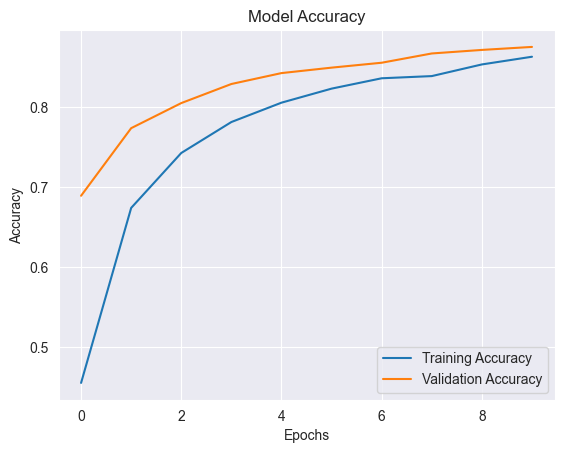

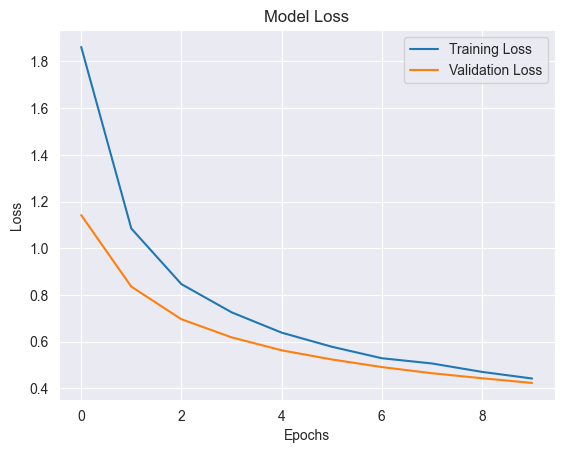

In [39]:
import matplotlib.pyplot as plt

# Load history to verify
with open('training_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

# Plot Accuracy
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


                                               filepaths            labels  \
15218  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_Good   
10735  C:\Users\vivek\Downloads\archive (1)\Processed...         Lime_Good   
2910   C:\Users\vivek\Downloads\archive (1)\Processed...         Guava_Bad   
437    C:\Users\vivek\Downloads\archive (1)\Processed...         Apple_Bad   
9741   C:\Users\vivek\Downloads\archive (1)\Processed...        Guava_Good   
16858  C:\Users\vivek\Downloads\archive (1)\Processed...  Pomegranate_Good   

                   pred  
15218  Pomegranate_Good  
10735         Lime_Good  
2910          Guava_Bad  
437           Apple_Bad  
9741         Guava_Good  
16858  Pomegranate_Good  


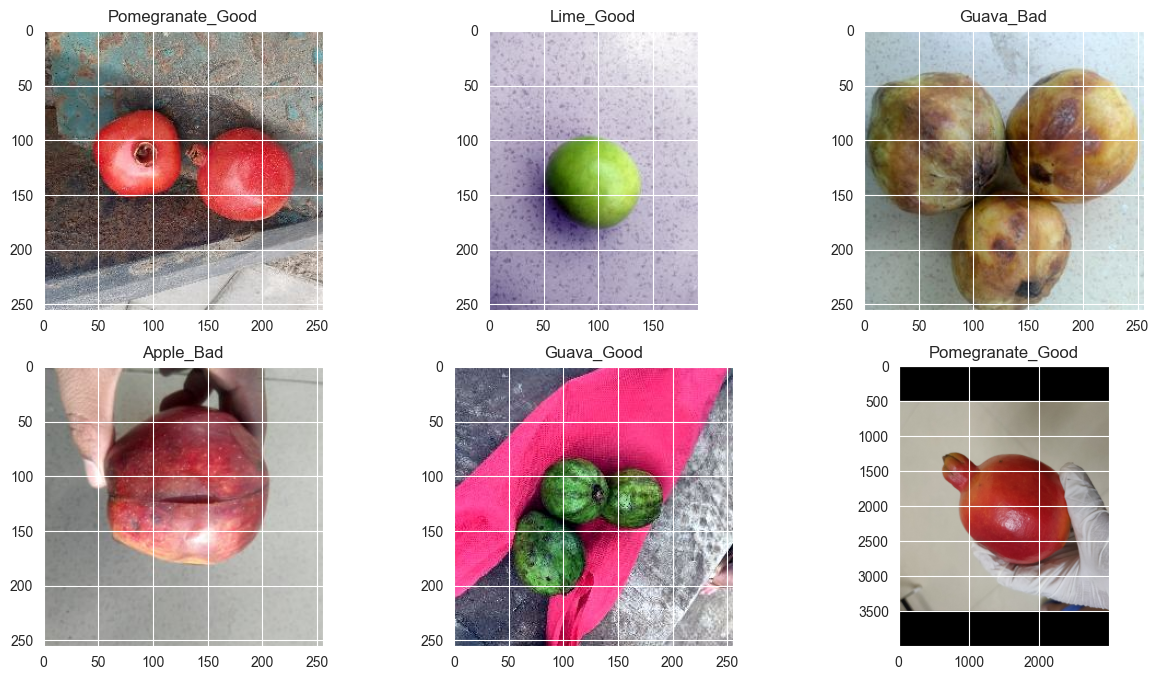

In [43]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(6))
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(6).reset_index()
for i in range(0,6):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])

1/1 [==============================] - 0s 64ms/step


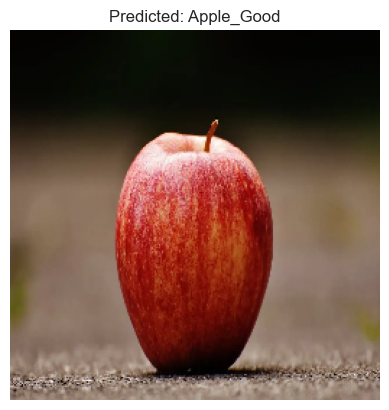

Predicted Class: Apple_Good


In [44]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image from file path
img_path = r'C:\Users\vivek\OneDrive\Desktop\fruit_quality_project\66ff018a4cf0ec04726a4f72_66e1de2c451773de3a59d640_are-apples-good-for-type-2-diabetes.webp'
img = image.load_img(img_path, target_size=(256, 256))  # Resize to the input size your model expects (e.g., 224x224 for InceptionResNetV2)

# Step 2: Preprocess the image
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension to match the batch size (1 image in batch)
img_array = img_array / 255.0  # Normalize if your model was trained with normalized data (0-1 range)

# Step 3: Make predictions
pred = model.predict(img_array)

# Step 4: Get the predicted class
pred_class_index = np.argmax(pred, axis=1)[0]  # Get the class index
class_names = ['Apple_Bad',
 'Apple_Good',
 'Apple_mixed',
 'Banana_Bad',
 'Banana_Good',
 'Banana_mixed',
 'Guava_Bad',
 'Guava_Good',
 'Guava_mixed',
 'Lemon_mixed',
 'Lime_Bad',
 'Lime_Good',
 'Orange_Bad',
 'Orange_Good',
 'Orange_mixed',
 'Pomegranate_Bad',
 'Pomegranate_Good',
 'Pomegranate_mixed']  # Add your class names here
pred_class = class_names[pred_class_index]  # Map index to class name

# Step 5: Display the image and the predicted class
plt.imshow(img)
plt.title(f"Predicted: {pred_class}")
plt.axis('off')  # Hide axes
plt.show()

# Optionally print the predicted class
print(f"Predicted Class: {pred_class}")


In [36]:
model.save('inception_resnetv2_fruit_quality2ndtime.keras')

Loading the model

In [4]:
loaded_model = tf.keras.models.load_model('inception_resnetv2_fruit_quality2ndtime.keras')

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate test generator
testGen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

# Load test data
X_test_img = testGen.flow_from_dataframe(dataframe=X_test,
                                         x_col='filepaths',
                                         y_col='labels',
                                         class_mode='categorical',
                                         batch_size=32,
                                         shuffle=False)

# Get class labels
class_labels = list(X_test_img.class_indices.keys())
print(f"Class labels: {class_labels}")


Found 3668 validated image filenames belonging to 18 classes.
Class labels: ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', 'Banana_Good', 'Banana_mixed', 'Guava_Bad', 'Guava_Good', 'Guava_mixed', 'Lemon_mixed', 'Lime_Bad', 'Lime_Good', 'Orange_Bad', 'Orange_Good', 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']


115/115 [==============================] - 48s 364ms/step
📊 Classification Report:
                   precision    recall  f1-score   support

        Apple_Bad       0.87      0.92      0.90       223
       Apple_Good       0.86      0.85      0.86       241
      Apple_mixed       0.78      0.70      0.74        20
       Banana_Bad       0.97      0.96      0.97       219
      Banana_Good       0.89      0.99      0.94       248
     Banana_mixed       0.76      0.42      0.54        53
        Guava_Bad       0.92      0.89      0.91       247
       Guava_Good       0.93      0.87      0.90       226
      Guava_mixed       0.89      0.32      0.47        25
      Lemon_mixed       0.94      0.62      0.75        53
         Lime_Bad       0.73      0.81      0.77       200
        Lime_Good       0.89      0.85      0.87       231
       Orange_Bad       0.84      0.76      0.80       241
      Orange_Good       0.80      0.87      0.83       224
     Orange_mixed       0.80   

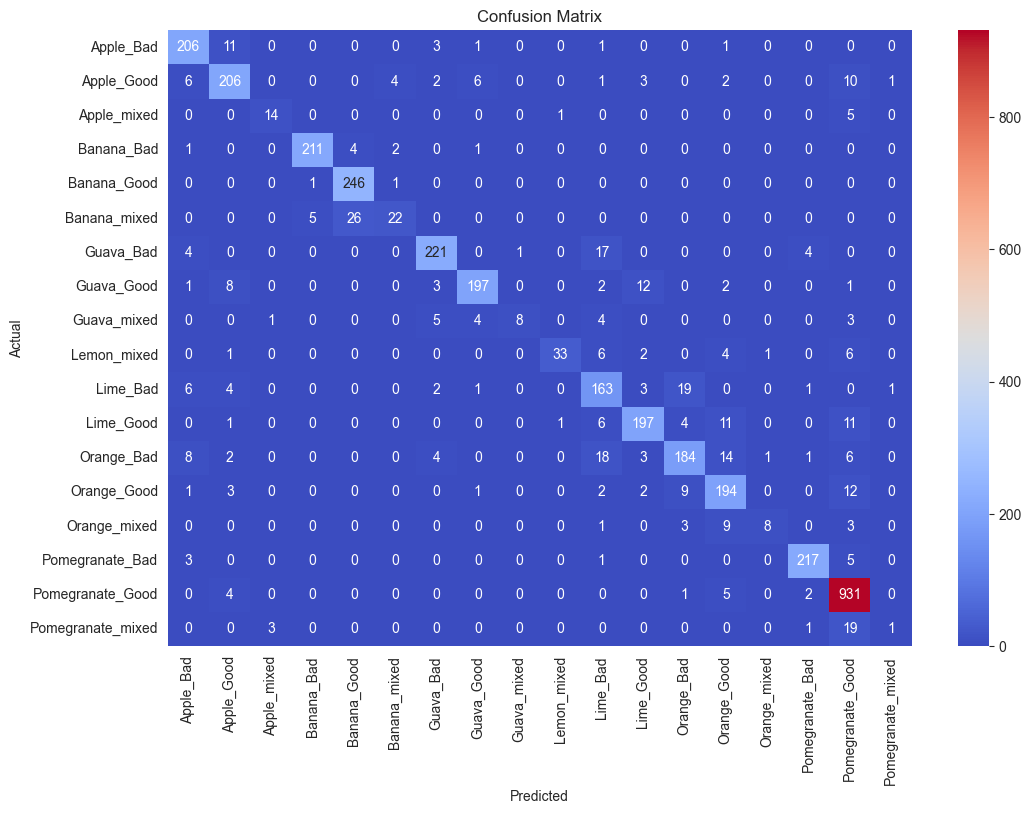

In [12]:
# Generate predictions from the loaded model
pred = loaded_model.predict(X_test_img)
pred_labels = np.argmax(pred, axis=1)

# Map predicted class indices to class names
labels = {v: k for k, v in X_test_img.class_indices.items()}
pred_class_names = [labels[idx] for idx in pred_labels]

# Create a copy of X_test and add predictions
pred_df = X_test.copy()
pred_df['pred'] = pred_class_names

# Generate and print classification report
print("📊 Classification Report:")
print(classification_report(pred_df['labels'], pred_df['pred']))

# Generate confusion matrix
cm = confusion_matrix(pred_df['labels'], pred_df['pred'])

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Defining class names

In [6]:
class_names = ['Apple_Bad',
 'Apple_Good',
 'Apple_mixed',
 'Banana_Bad',
 'Banana_Good',
 'Banana_mixed',
 'Guava_Bad',
 'Guava_Good',
 'Guava_mixed',
 'Lemon_mixed',
 'Lime_Bad',
 'Lime_Good',
 'Orange_Bad',
 'Orange_Good',
 'Orange_mixed',
 'Pomegranate_Bad',
 'Pomegranate_Good',
 'Pomegranate_mixed'] 

1/1 [==============================] - 0s 157ms/step


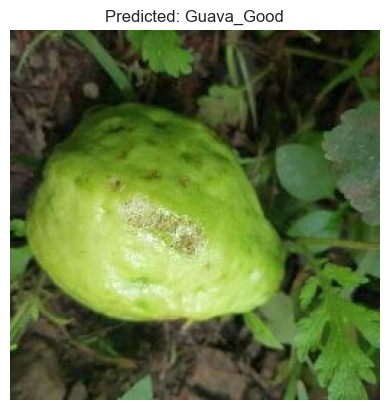

✅ Predicted Class: Guava_Good


In [8]:
from tensorflow.keras.preprocessing import image

# Path to the test image
img_path = r'C:\Users\vivek\OneDrive\Desktop\fruit_quality_project\test\Guava_Good\20190813_123049.jpg'

# Load the image and resize it
img = image.load_img(img_path, target_size=(256,256))  # Resize to match the input size
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(img_array)  # Preprocess

# Make prediction
pred = loaded_model.predict(img_array)
pred_class_index = np.argmax(pred, axis=1)[0]
pred_class = class_names[pred_class_index]

# Show the predicted result
plt.imshow(img)
plt.title(f"Predicted: {pred_class}")
plt.axis('off')
plt.show()

print(f"✅ Predicted Class: {pred_class}")


Grad-cam function

In [42]:
model = tf.keras.models.load_model('inception_resnetv2_fruit_quality.keras')

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 18)                27666 

In [2]:

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


Fine tuning the model
